In [6]:
import csv
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# Converting binary data to images and label, uncomment for new data

In [ ]:
# def save_images_from_csv(storage, data, out_folder, labels, training, img_height, img_width):
#     training_folder = os.path.join(storage, "Training_folder")  # Single folder for everything
#     full_extracted_dir = os.path.join(training_folder, out_folder)
#     csv_training_file = os.path.join(training_folder, training)  # Training_data.csv in Training_folder

#     # Create Training_folder and subfolders for sorted labeled images
#     if not os.path.exists(training_folder):
#         os.makedirs(training_folder, exist_ok=True)

#     sorted_labeled_dir = os.path.join(training_folder, "Sorted_Labeled_Images")
#     if not os.path.exists(full_extracted_dir):
#         os.makedirs(full_extracted_dir, exist_ok=True)
        
#     if not os.path.exists(sorted_labeled_dir):
#         os.makedirs(sorted_labeled_dir, exist_ok=True)
#     for label in labels:
#         label_subfolder = os.path.join(sorted_labeled_dir, label)
#         if not os.path.exists(label_subfolder):
#             os.makedirs(label_subfolder, exist_ok=True)

#     directory = os.path.dirname(csv_training_file)
#     if not os.path.exists(directory):
#         print(f"Directory {directory} does not exist! Creating it.")
#         os.makedirs(directory, exist_ok=True)
#     else:
#         print(f"Directory {directory} exists.")

#     try:
#         with open(csv_training_file, mode='w', newline='') as csvfile:
#             csv_writer = csv.writer(csvfile)
#             csv_writer.writerow(["Image Path", "label", "Error", "Angle"])
#             print(f"Created or opened {csv_training_file} for writing.")
#     except PermissionError as e:
#         print(f"PermissionError: {e}")
#         return

#     try:
#         with open(os.path.join(storage, data), "r") as file:
#             lines = file.readlines()
#     except FileNotFoundError:
#         print(f"Error: {os.path.join(storage, data)} not found!")
#         return

#     images = []
#     current_image = []
#     for line in lines:
#         line = line.strip()
#         if not line:
#             continue
#         row_data = [int(val) if val.strip().isdigit() else 0 for val in line.split(",")]
#         if len(row_data) == img_width:
#             current_image.append(row_data)
#         if len(current_image) == img_height:
#             images.append(np.array(current_image, dtype=np.uint8))
#             current_image = []

#     Center = img_width // 2  # 160
#     On_Track_Margin = 15     # ±15 from 160 for On_Track
#     Slight_Margin = 35       # ±35 for slight deviations

#     for idx, binary_image in enumerate(images):
#         # Check if the image is fully black (Off_Track)
#         total_white_pixels = np.sum(binary_image == 1)
#         if total_white_pixels == 0:
#             label = "Off_Track"
#             error = None
#             angle = None
#             avg_x = None
#             left_branch_pixels = 0
#             right_branch_pixels = 0
#             vertical_pixels = 0
#         else:
#             # Compute the mean x-coordinate of white pixels in each row
#             cols_per_row = []
#             for row in range(img_height):
#                 white_cols = np.where(binary_image[row, :] == 1)[0]
#                 cols_per_row.append(np.mean(white_cols) if len(white_cols) > 0 else None)

#             # Filter out None values and compute average x-position across all rows
#             valid_cols = [col for col in cols_per_row if col is not None]
#             avg_x = np.mean(valid_cols) if valid_cols else None

#             # Default values
#             error = None
#             angle = None
#             left_branch_pixels = 0
#             right_branch_pixels = 0
#             vertical_pixels = 0

#             if avg_x is not None:
#                 # Compute error (distance from center)
#                 error = avg_x - Center

#                 # Fit a line to detect angle (optional, kept for CSV)
#                 rows_with_cols = [(row, col) for row, col in enumerate(cols_per_row) if col is not None]
#                 if len(rows_with_cols) > 1:
#                     rows, cols = zip(*rows_with_cols)
#                     coeffs = np.polyfit(rows, cols, 1)  # [slope, intercept]
#                     slope = coeffs[0]
#                     angle = math.degrees(math.atan(slope))  # Positive = right, negative = left
#                 else:
#                     angle = 0

#                 # Enhanced Junction and Crossroad detection
#                 mid_row = img_height
#                 # Widen detection regions slightly
#                 left_branch_pixels = np.sum(binary_image[:, :80] == 1)  # Left side (0 to 80)
#                 right_branch_pixels = np.sum(binary_image[:, 240:] == 1)  # Right side (240 to 320)
#                 branch_threshold = 1  # Lowered for more sensitivity
#                 vertical_pixels = np.sum(binary_image[:, 110:210] == 1)  # Wider middle region (110 to 210)
#                 has_vertical = vertical_pixels > 300  # Lowered for more sensitivity

#                 # Classification logic
#                 # if has_vertical and left_branch_pixels > branch_threshold and right_branch_pixels > branch_threshold:
#                 if left_branch_pixels > branch_threshold and right_branch_pixels > branch_threshold:
#                     label = "Crossroad"
#                 elif has_vertical and left_branch_pixels > branch_threshold:
#                     label = "Left_Junction"
#                 elif has_vertical and right_branch_pixels > branch_threshold:
#                     label = "Right_Junction"
#                 else:
#                     # Classify based on position (error) only if not a junction
#                     if -On_Track_Margin <= error <= On_Track_Margin:
#                         label = "On_Track"
#                     elif -Slight_Margin < error < -On_Track_Margin:
#                         label = "Slight_Left"  # Between -35 and -15
#                     elif Slight_Margin > error > On_Track_Margin:
#                         label = "Slight_Right"  # Between 15 and 35
#                     else:
#                         # Extend Slight ranges for extreme cases
#                         if error < -Slight_Margin:
#                             label = "Slight_Left"
#                         elif error > Slight_Margin:
#                             label = "Slight_Right"

#         # Enhanced debugging output
#         print(f"idx={idx}, avg_x={avg_x}, error={error}, angle={angle}, "
#               f"left_branch_pixels={left_branch_pixels}, right_branch_pixels={right_branch_pixels}, "
#               f"vertical_pixels={vertical_pixels}, label={label}")
        
#         # Save the image
#         if binary_image.shape == (img_height, img_width):
#             grayscale_image = (binary_image * 255).astype(np.uint8)

#             # Save in Training_folder/Full_Extracted_images
#             full_img_path = os.path.join(full_extracted_dir, f"Image_{idx+1}_{label}.png")
#             cv2.imwrite(full_img_path, grayscale_image)
#             print(f"Saved to Training_folder/Full_Extracted_images: {full_img_path}")

#             # Save in Training_folder/Sorted_Labeled_Images
#             sorted_label_path = os.path.join(sorted_labeled_dir, label)
#             sorted_img_path = os.path.join(sorted_label_path, f"image_{idx+1}.png")
#             cv2.imwrite(sorted_img_path, grayscale_image)
#             print(f"Saved to Training_folder/Sorted_Labeled_Images/{label}: {sorted_img_path}")

#             # Write to Training_data.csv in Training_folder
#             with open(csv_training_file, mode='a', newline='') as csvfile:
#                 csv_writer = csv.writer(csvfile)
#                 csv_writer.writerow([full_img_path, label, error, angle])
#         else:
#             print(f"Skipping invalid shape {binary_image.shape} at index {idx+1}")

# # Example usage
# storage_path = r"Line_detection_Group"
# data_path = r"Data_storage.csv"
# output_folder = "Full_Extracted_images"
# labels = ["On_Track", "Slight_Left", "Slight_Right", "Off_Track", "Crossroad", "Left_Junction", "Right_Junction"]
# training_path = r"Training_data.csv"

# image_height = 50
# image_width = 320

# save_images_from_csv(storage_path, data_path, output_folder, labels, training_path, image_height, image_width)

# Loading train and test dataset

In [ ]:

# Load Training and preprocess data
Path_Dataset = "Line_detection_Group_3"
CSV_File = "T/Training_data.csv"
Train_data = pd.read_csv(os.path.join(Path_Dataset,CSV_File))
# data = pd.read_csv("Line_detection_Group/Training_data.csv")
# label_map = {"Left": 0, "On_Track": 1, "Off_Track": 2, "Right": 3}
# label_map = {
#     "Crossroad": 0,
#     "Heavy_Left": 1,
#     "Heavy_Right": 2,
#     "Left_Junction": 3,
#     "Off_Track": 4,
#     "On_Track": 5,
#     "Right_Junction": 6,
#     "Slight_Left": 7,
#     "Slight_Right": 8
# }

# label_map = {
#     "Off_Track": 0,
#     "Crossroad": 1,
#     "Left_Junction": 2,
#     "Right_Junction": 3,
#     "On_Track": 4,
#     "Slight_Left": 5,
#     "Slight_Right": 6
# }

label_map = {
    "Crossroad": 0,
    "Left_Junction": 1,
    "Off_Track": 2,
    "On_Track": 3,
    "Right_Junction": 4,
    "Slight_Left": 5,
    "Slight_Right": 6
}

Train_data['label'] = Train_data['label'].map(label_map)
# print(Train_data)


class_names = {v: k for k, v in label_map.items()}
print("Class names:", class_names)
print(f"Total Class: {len(class_names)}")
label_counts = Train_data['label'].value_counts()

for label_idx in range(len(class_names)):
    count = label_counts.get(label_idx, 0)  # Use .get() to handle missing labels (defaults to 0)
    class_name = class_names[label_idx]
    print(f"{class_name}: {count} images")

Class names: {0: 'Crossroad', 1: 'Left_Junction', 2: 'Off_Track', 3: 'On_Track', 4: 'Right_Junction', 5: 'Slight_Left', 6: 'Slight_Right'}
Total Class: 7
Crossroad: 351 images
Left_Junction: 462 images
Off_Track: 260 images
On_Track: 903 images
Right_Junction: 377 images
Slight_Left: 1947 images
Slight_Right: 436 images


In [122]:
class QbotImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image Path']  
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        label = self.dataframe.iloc[idx]['label']  # Extract label
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip()
])


## Training dataset

In [123]:
Train_Image = "T/Full_Extracted_images"
Train_dataset = QbotImageDataset(Train_data, transform=transform)
Train_loader = DataLoader(Train_dataset, batch_size=32, shuffle=True)
Train_dataset_size = len(Train_dataset) #int(0.8 * len(dataset))

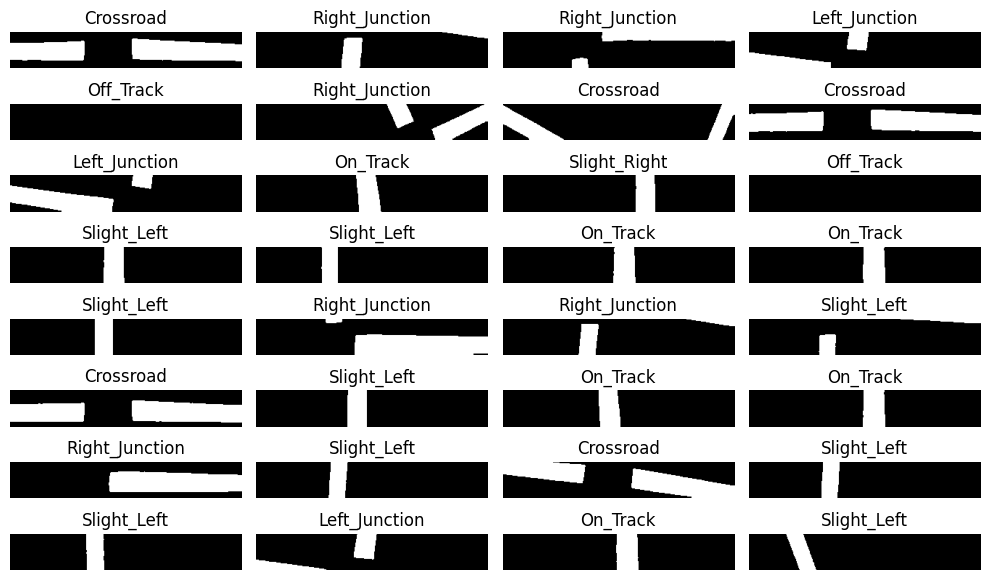

In [124]:
X_batch, y_batch = next(iter(Train_loader))
X_batch_size = len(X_batch)
# class_names = Train_dataset.classes

# Function to convert tensor to image for visualization
def convert_tensor_to_image(input):
    input = input.numpy().transpose((1, 2, 0))
    mean = 0.5
    std = 0.5
    output = std * input + mean
    output = np.clip(output, 0, 1)
    return output

# Visualize the batch
nrows, ncols = 8, 4
# import math
# nrows = math.ceil(X_batch_size / ncols)

plt.figure(figsize=(10, 6))
for i in range(X_batch_size):
    img = convert_tensor_to_image(X_batch[i])
    # print(f"i+1: {i+1}, nrows: {nrows}, ncols: {ncols}, total: {nrows * ncols}")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img, cmap='gray')  # Add cmap='gray' since images are grayscale
    # plt.imshow(img)
    plt.axis('off')
    # plt.title(f"{class_names[y_batch[i]]}")
    # plt.title(f"{reverse_label_map[y_batch[i].item()]}")
    plt.title(class_names.get(y_batch[i].item()))

plt.tight_layout()
plt.show()

## Testing dataset

In [125]:
# Load Test and preprocess data
Test_dir = "T/Sorted_Labeled_Images"
Test_dataset = datasets.ImageFolder(os.path.join(Path_Dataset,Test_dir), transform=transform)
Test_loader = DataLoader(Test_dataset, batch_size=32, shuffle=False)
Test_dataset_size = len(Test_dataset)
print(f"Test_dataset_size = {Test_dataset_size}")
class_names_T = Test_dataset.classes
print(f"Classifications =  {class_names_T}, Total = {len(class_names_T)}")

Test_dataset_size = 4736
Classifications =  ['Crossroad', 'Left_Junction', 'Off_Track', 'On_Track', 'Right_Junction', 'Slight_Left', 'Slight_Right'], Total = 7


In [126]:
import os
test_dir = os.path.join(Path_Dataset, Test_dir)
subfolders = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
print("Subfolders found:", subfolders)
print("Number of subfolders:", len(subfolders))
for subfolder in subfolders:
    num_images = len(os.listdir(os.path.join(test_dir, subfolder)))
    print(f"{subfolder}: {num_images} images")


Subfolders found: ['Crossroad', 'Left_Junction', 'Off_Track', 'On_Track', 'Right_Junction', 'Slight_Left', 'Slight_Right']
Number of subfolders: 7
Crossroad: 351 images
Left_Junction: 462 images
Off_Track: 260 images
On_Track: 903 images
Right_Junction: 377 images
Slight_Left: 1947 images
Slight_Right: 436 images


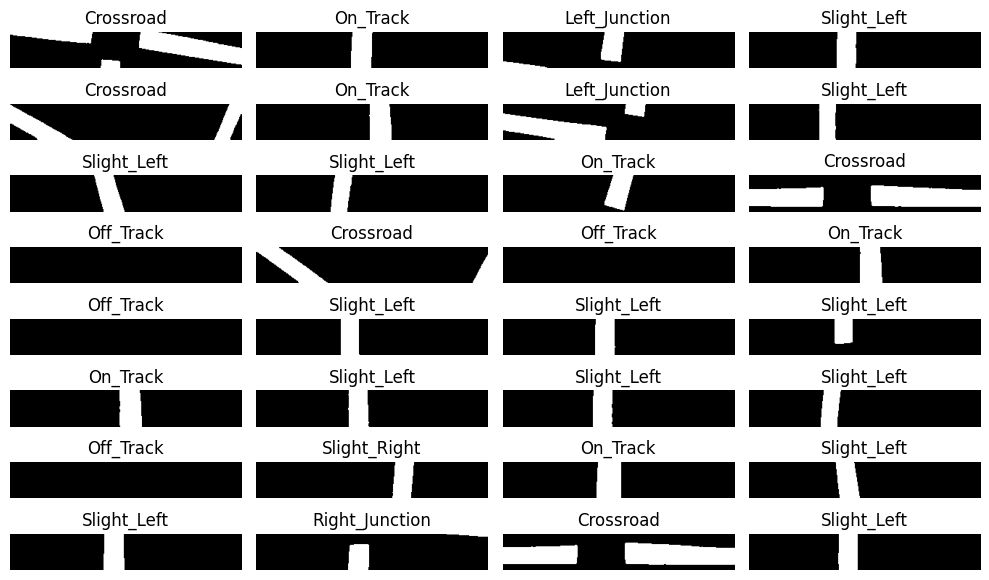

In [127]:
Test_loader_Check = DataLoader(Test_dataset, batch_size=32, shuffle=True)
X_batch_T, y_batch_T = next(iter(Test_loader_Check))
X_batch_size_T = len(X_batch_T)

# Function to convert tensor to image for visualization
def convert_tensor_to_image_T(input):
    input_T = input.numpy().transpose((1, 2, 0))
    mean = 0.5
    std = 0.5
    output_T = std * input_T + mean
    output_T = np.clip(output_T, 0, 1)
    return output_T

# Visualize the batch
nrows, ncols = 8, 4
# import math
# nrows = math.ceil(X_batch_size / ncols)

plt.figure(figsize=(10, 6))
for i in range(X_batch_size_T):
    img_T = convert_tensor_to_image_T(X_batch_T[i])
    # print(f"i+1: {i+1}, nrows: {nrows}, ncols: {ncols}, total: {nrows * ncols}")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img_T, cmap='gray')  # Add cmap='gray' since images are grayscale
    plt.axis('off')
    plt.title(f"{class_names_T[y_batch_T[i]]}")
    # plt.title(f"{reverse_label_map[y_batch[i].item()]}")
    # plt.title(class_names_T.get(y_batch_T[i]))

plt.tight_layout()
plt.show()

In [128]:
print(f"X_batch.shape = {X_batch.shape}")
print(f"Train_dataset_size = {Train_dataset_size}")
print(f"Test_dataset_size = {Test_dataset_size}")
print(f"Classifications =  {class_names}")
print(f"Total = {len(class_names)}")

X_batch.shape = torch.Size([32, 1, 50, 320])
Train_dataset_size = 4736
Test_dataset_size = 4736
Classifications =  {0: 'Crossroad', 1: 'Left_Junction', 2: 'Off_Track', 3: 'On_Track', 4: 'Right_Junction', 5: 'Slight_Left', 6: 'Slight_Right'}
Total = 7


In [129]:
class LineFollowerCNN(nn.Module):
    def __init__(self):
        super(LineFollowerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc1 = nn.Linear(64 * 6 * 40, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 7)  # 7 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model = LineFollowerCNN()

In [130]:
outputs = model(X_batch)
print(f"Output shape: {outputs.shape}")


Output shape: torch.Size([32, 7])


In [131]:
for images, labels in Train_loader:
    print("Train batch shape:", images.shape)
    break
for images, labels in Test_loader:
    print("Test batch shape:", images.shape)
    break

Train batch shape: torch.Size([32, 1, 50, 320])
Test batch shape: torch.Size([32, 1, 50, 320])


In [132]:
def train_model(model, path_to_state, criterion, optimizer, scheduler, Train_loader, Train_dataset_size, Test_loader, Test_dataset_size, epochs):
    # Load model weights if checkpoint exists
    my_file = Path(path_to_state)
    if my_file.is_file():
        model.load_state_dict(torch.load(path_to_state, weights_only=True))

    # model = model.to(device)

    best_accuracy = 0.0
    since = time.time()

    for epoch in range(1, epochs + 1):
        print(f"Epoch [{epoch}/{epochs}]")
        
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for images, labels in Train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            logits = model(images)  # Forward pass
            loss = criterion(logits, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            preds = torch.argmax(logits, dim=1)  # Get predicted class labels
            running_loss += loss.item() * images.size(0)  # Sum loss over batch
            running_corrects += torch.sum(preds == labels).item()  # Count correct predictions
        
        # Compute epoch loss & accuracy
        epoch_loss = running_loss / Train_dataset_size
        epoch_accuracy = running_corrects / Train_dataset_size
        print(f"Train Loss: {epoch_loss:.5f} -- Accuracy: {epoch_accuracy:.4f}")

        # testation phase
        model.eval()
        running_loss, running_corrects = 0.0, 0

        with torch.no_grad():  # Disable gradient computation
            for images, labels in Test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                preds = torch.argmax(logits, dim=1)
                loss = criterion(logits, labels)
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels).item()

        # Compute testation loss & accuracy
        epoch_test_loss = running_loss / Test_dataset_size
        epoch_test_accuracy = running_corrects / Test_dataset_size
        print(f"Test Loss: {epoch_test_loss:.5f} -- Accuracy: {epoch_test_accuracy:.4f}")

        # Step the scheduler with testation accuracy
        scheduler.step(epoch_test_accuracy)

        # Save the model if testation accuracy improves
        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            torch.save(model.state_dict(), path_to_state)
            print(f"New best accuracy: {best_accuracy:.4f} - Model saved to {path_to_state}")

        # Print learning rate to verify
        for param_group in optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")

        print(60 * "=")

    print(f"Best test accuracy: {best_accuracy * 100:.2f}%")
    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    return model

In [133]:
from collections import Counter
train_labels = [label.item() for _, labels in Train_loader for label in labels]
test_labels = [label.item() for _, labels in Test_loader_Check for label in labels]
print("Train class distribution:", Counter(train_labels))
print("Test class distribution:", Counter(test_labels))

Train class distribution: Counter({5: 1947, 3: 903, 1: 462, 6: 436, 4: 377, 0: 351, 2: 260})
Test class distribution: Counter({5: 1947, 3: 903, 1: 462, 6: 436, 4: 377, 0: 351, 2: 260})


In [134]:
model = LineFollowerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
path_to_state = "line_follower_cnn_improve.pth"
epochs = 10

# Train the model
trained_model = train_model(model, path_to_state, criterion, optimizer, scheduler, Train_loader, Train_dataset_size, Test_loader, Test_dataset_size, epochs)

Epoch [1/10]


C:\Users\leewe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 0.33737 -- Accuracy: 0.9272
Test Loss: 0.01968 -- Accuracy: 0.9932
New best accuracy: 0.9932 - Model saved to line_follower_cnn_improve.pth
Learning Rate: 0.001
Epoch [2/10]
Train Loss: 0.03006 -- Accuracy: 0.9922
Test Loss: 0.01527 -- Accuracy: 0.9954
New best accuracy: 0.9954 - Model saved to line_follower_cnn_improve.pth
Learning Rate: 0.001
Epoch [3/10]
Train Loss: 0.02106 -- Accuracy: 0.9941
Test Loss: 0.01093 -- Accuracy: 0.9960
New best accuracy: 0.9960 - Model saved to line_follower_cnn_improve.pth
Learning Rate: 0.001
Epoch [4/10]
Train Loss: 0.02203 -- Accuracy: 0.9939
Test Loss: 0.00329 -- Accuracy: 0.9989
New best accuracy: 0.9989 - Model saved to line_follower_cnn_improve.pth
Learning Rate: 0.001
Epoch [5/10]
Train Loss: 0.01360 -- Accuracy: 0.9951
Test Loss: 0.00343 -- Accuracy: 0.9994
New best accuracy: 0.9994 - Model saved to line_follower_cnn_improve.pth
Learning Rate: 0.001
Epoch [6/10]
Train Loss: 0.01469 -- Accuracy: 0.9956
Test Loss: 0.00562 -- Accuracy

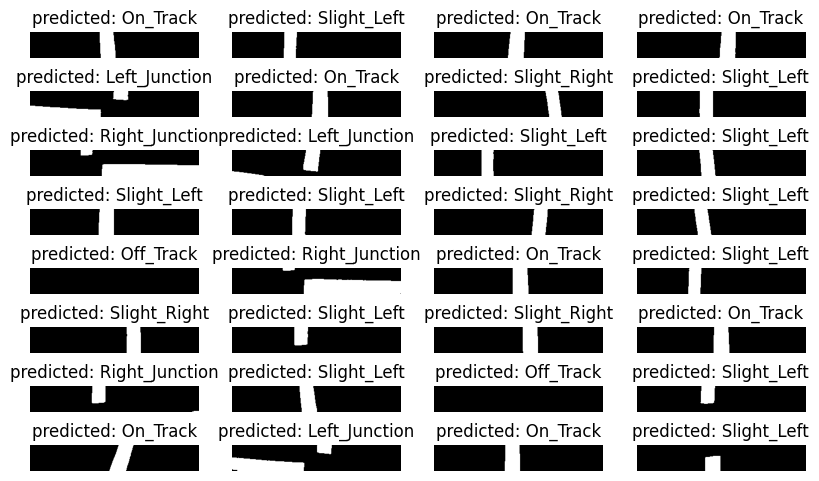

In [135]:
def visualize_result(model, nrows, ncols, num_images):
    was_training = model.training
    images_so_far = 0
    total = len(Test_dataset)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(Test_loader_Check):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
      
            inputs = inputs.cpu()
            plt.figure(figsize=(10, 6))
            for j in range(inputs.shape[0]):
                images_so_far += 1
                
                plt.subplot(nrows, ncols, images_so_far)

                plt.imshow(convert_tensor_to_image(inputs[j]), cmap='gray')
                plt.axis('off')

                plt.title(f"predicted: {class_names[preds[j].item()]}")
            
                if images_so_far == num_images:
                    model.train(mode=was_training)                
                    return 
            plt.tight_layout()

            
    model.train(mode=was_training)

visualize_result(model, nrows=8, ncols=4, num_images=32)

## Confusion matrix for the trained model

C:\Users\leewe\AppData\Local\Temp\ipykernel_59948\304480839.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=de

Model Accuracy: 99.92%


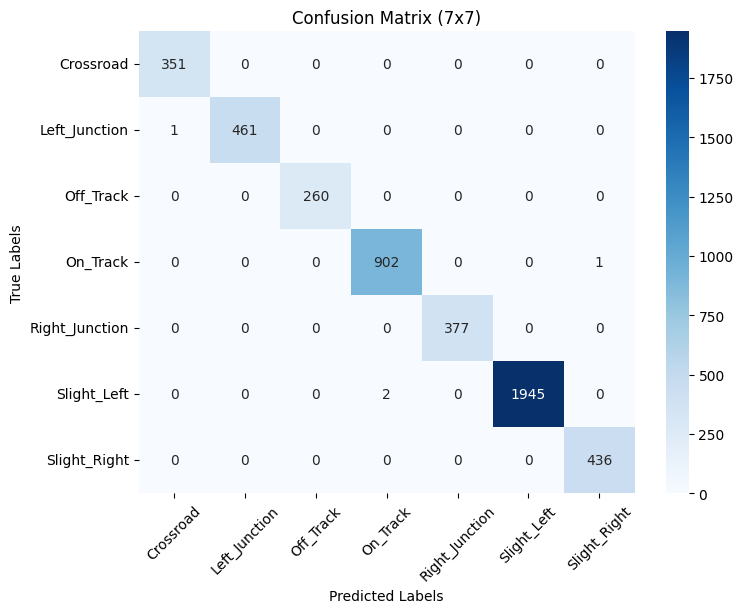

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define the CNN model
class LineFollowerCNN(nn.Module):
    def __init__(self):
        super(LineFollowerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 6 * 40, 128)  # Adjusted based on input size
        self.fc2 = nn.Linear(128, 7)  # 7 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = LineFollowerCNN().to(device)

# Load the trained weights from .pth file
MODEL_PATH = "line_follower_cnn_improve.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # Load model to correct device
model.eval()  # Set to evaluation mode

# Define data transformations (adjust based on training settings)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single channel
    transforms.Resize((50, 320)),  # Resize to match model input size
    transforms.ToTensor()
])

# Load test dataset
TEST_DATASET_PATH = "Line_detection_Group_3/T/Sorted_Labeled_Images"
test_dataset = ImageFolder(root=TEST_DATASET_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get true labels and predictions
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class
        y_true.extend(labels.cpu().numpy())  # Convert to NumPy
        y_pred.extend(preds.cpu().numpy())  # Convert to NumPy

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

class_labels = test_dataset.classes  # Folder names as labels

# Plot confusion matrix with actual class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (7x7)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.yticks(rotation=0)
plt.show()

### Justification for Confusion Matrix Analysis
The confusion matrix provides a detailed evaluation of the classification performance of our trained Convolutional Neural Network (CNN) model for line-following navigation. The matrix showcases the model’s ability to correctly classify seven different navigation categories: Crossroad, Left_Junction, Off_Track, On_Track, Right_Junction, Slight_Left, and Slight_Right.

1. High Accuracy and Strong Diagonal Pattern
The diagonal dominance in the confusion matrix indicates that the model performs well in classifying most of the categories accurately. The majority of predictions align with the true labels, signifying a high classification accuracy. This is particularly evident for classes such as:

- On_Track (902 correct predictions)

- Slight_Left (1945 correct predictions)

- Slight_Right (436 correct predictions)

These results suggest that the CNN effectively learns to differentiate between these classes.

2. Minimal Misclassifications
There are very few off-diagonal values, indicating that misclassifications are rare. The most notable misclassification occurs in the "On_Track" class, where one sample was misclassified as another category. Additionally, the "Left_Junction" category shows a single incorrect classification. However, given the overall dataset size, these errors are negligible and do not significantly impact model performance.

3. Implications for Real-World Deployment
The strong classification performance ensures that the robotic system can reliably distinguish between different track conditions, making it well-suited for autonomous navigation.

The low misclassification rate reduces the likelihood of incorrect movements, ensuring smooth and accurate robot control.

Future improvements could focus on fine-tuning the model to eliminate rare misclassifications, possibly by increasing dataset size or applying more advanced augmentation techniques 
- Sharp_Left
- Sharp_Right
- Moderate_Left 
- Moderate_Right
- Curving_Left
- Curving_Right
- Explicit_T_Junction
- Cross_Junction

Conclusion
The confusion matrix demonstrates that the CNN model is highly effective at classifying navigation states with minimal errors. The observed high accuracy and low misclassification rate validate the model’s suitability for deployment in a line-following robotic system.